## PCA on electrophysiology data

In this notebook, we will apply PCA on electrophysiology data. Here, we'll work with a sample data set (data_for_exercises.mat). 
This dataset contains spike counts for 97 neurons recorded using an electrode array over the dorsal premotor cortex of a monkey during a reaching task. Each row of the dataset (728) is a different trial for a different angle of reaching (8 angles total). Trials 1-91 are for reach angle 1, 92-182 for reach angle 2, etc.

You can read more about the experiments that created this dataset [here](https://www.jneurosci.org/content/27/40/10742).

In [1]:
import scipy.io
from collections import defaultdict
import scipy.stats as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

### Loading the data

In [2]:
matIn = scipy.io.loadmat('data_for_exercises.mat')
data = matIn['Xplan']
num_trials, num_neurons = data.shape
print(num_trials, num_neurons)

728 97


<div class="alert alert-success">

**Task**: Implement the main steps of PCA as discussed in class
</div>

In [3]:
# Subtract the mean of X
X = data - data.mean(0)

# Calculate the covariance matrix (hint: use np.matmul)
cov_matrix = (X.T @ X)/len(X)

# Calculate the eigenvalues and eigenvectors
evals, evectors =  np.linalg.eigh(cov_matrix) # hint: use np.linalg.eigh

# Sort the eigenvalues in descending order using a helper function
index = np.argsort(evals)[::-1]
evals = evals[index]
evectors = evectors[:, index] 

# Project the data onto the new eigenvector basis
transformed_data =  X @ evectors # hint: remember U = XV

# Compute variance explained by each component (eigenvalue / sum of eigenvalues)
explained_variance_ratio = evals / evals.sum()

# Compute reconstructions (remember X = UV^T)

## Reconstruction of deameaned data 
recon_X = transformed_data @ evectors.T

## Reconstruction of original data. Hint: Add back the mean 
recon_D = transformed_data @ evectors.T + data.mean(0)

In [4]:
# Assign the angles column here
angles = []
angle_names = range(1,9)
angle_start = np.arange(0,728,91)
angle_end = np.arange(91,729,91)

for angle in range(8):
    for trial in range(angle_start[angle],angle_end[angle]):
        angles.append(angle_names[angle])
len(angles)

728

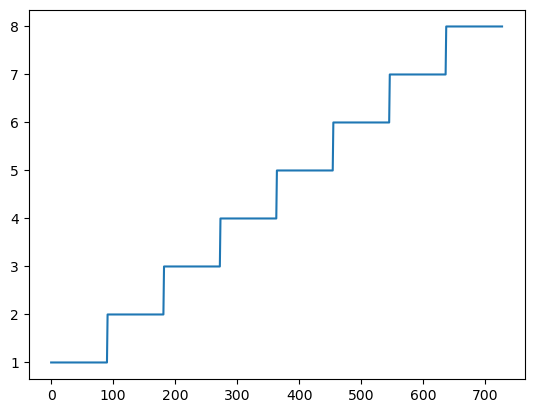

In [6]:
plt.plot(angles)

### Scree plot 

Let's examine the eigenvalues of the covariance matrix. Remember that each eigenvalue describes the variance of the data projected onto its corresponding eigenvector. This is an important concept because it allows us to rank the PCA basis vectors based on how much variance each one can capture. First run the code below to plot the eigenvalues (sometimes called the “scree plot”). 


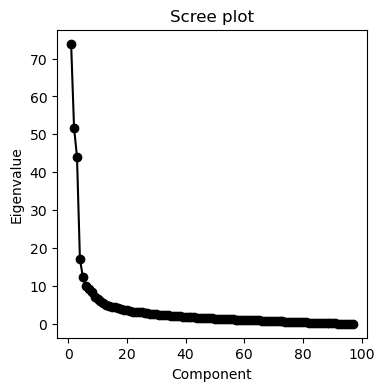

In [7]:
plt.figure(figsize=(4, 4))
plt.plot(np.arange(1, len(evals) + 1), evals, 'o-k')
plt.xlabel('Component')
plt.ylabel('Eigenvalue')
plt.title('Scree plot'); 

Based on this, how many components would you keep in the data? 

### Visualize projected data 

Now we can visualize the data projected onto the first 3 PCs

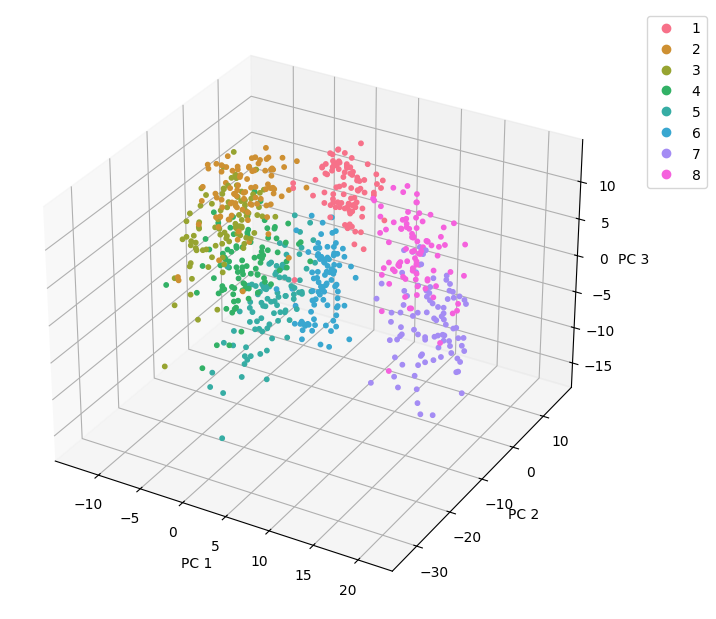

In [8]:
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

# get colormap from seaborn
cmap = ListedColormap(sns.color_palette("husl", 8).as_hex())

# plot
sc = ax.scatter(transformed_data[:,0], transformed_data[:,1], transformed_data[:,2], s=10, c = angles, marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
plt.savefig("scatter_hue", bbox_inches='tight')


In the above, we created our own functions to compute PCA so we could better understand the algorithms. Usually though, you would  use `sklearn.decomposition.pca` to perform PCA. 

See docs here: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html


In [9]:
# Import PCA class
from sklearn.decomposition import PCA

# Set up model, tell it the number of components you'll want to keep (if not set, all components will be kept)
pca = PCA(n_components = 97)

# Fit the model to your data, aka find the principal components
pca.fit(data)

# Now you can access the principal components
evectors2 = pca.components_.T #(In PCA's implementation, each row of pca.components_, rather than a column, represents an eigenvector so we take the transform

# And the % of explained variance for each component
explained_variance_ratio2 = pca.explained_variance_ratio_

# You can transform your data now
transformed_data2 = pca.transform(data)

# You could have fit and transformed at the same time if you had wanted
transformed_data2 = pca.fit_transform(data)

# You can also reconstruct into the original space
recon_X2 = pca.inverse_transform(transformed_data2) - pca.mean_ # Altenatively, you can also do: pca.inverse_transform(transformed_data2) - data.mean(0)
recon_D2 = pca.inverse_transform(transformed_data2) 

# Alternatively, you can also reconstruct the original data matrix as
recon_D2 = transformed_data2 @ evectors2.T + pca.mean_

Let's verify that the results obtained through sklearn PCA match our manual implementation

In [10]:
assert np.allclose(explained_variance_ratio, explained_variance_ratio2)
assert np.allclose(np.abs(evectors), np.abs(evectors2))
assert np.allclose(np.abs(transformed_data), np.abs(transformed_data2))
assert np.allclose(recon_X, recon_X2)
assert np.allclose(recon_D, recon_D2)